# 0.0. Imports

In [169]:
import optuna
import warnings
import pandas             as pd
import numpy              as np
import lightgbm           as lgb
import seaborn            as sns
import matplotlib.pyplot  as plt
import catboost           as cb
import matplotlib.patches as mpatches

from sklearn.decomposition   import PCA
from IPython.display         import HTML
from sklearn.manifold        import TSNE
from sklearn                 import metrics


from sklearn.preprocessing   import RobustScaler
from sklearn.preprocessing   import MinMaxScaler
from sklearn.preprocessing   import LabelEncoder
from sklearn.decomposition   import TruncatedSVD
from xgboost                 import XGBClassifier
from dataprep.eda            import create_report
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.ensemble        import RandomForestClassifier




warnings.filterwarnings('ignore')

## 0.1. Helper Functions


In [170]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )


    sns.set()
    
jupyter_settings()

In [214]:
def preprocessing( X_train, X_test, y_train ):
    
    ###### Fill NA
    
    X_train['Nacionalidade'] = X_train['Nacionalidade'].fillna('Spain')
    X_train['Número de hospedes'] = X_train['Número de hospedes'].fillna(int(X_train['Número de hospedes'].mode()))
    
    X_test['Nacionalidade'] = X_test['Nacionalidade'].fillna('Spain')
    X_test['Número de hospedes'] = X_test['Número de hospedes'].fillna(int(X_test['Número de hospedes'].mode()))
    
    
    ###### Change dtypes
    X_train['Número de hospedes'] = X_train['Número de hospedes'].astype('int32')
    X_train['Número de hospedes'] = X_train['Número de hospedes'].apply(lambda x: 8 if x > 5 else x)

    X_test['Número de hospedes'] = X_test['Número de hospedes'].astype('int32')
    X_test['Número de hospedes'] = X_test['Número de hospedes'].apply(lambda x: 8 if x > 5 else x)      
    
    ###### Rescaling
#     rs_meses_reserva_checkin = RobustScaler()
#     X_train['Meses da reserva até o check-in'] = rs_meses_reserva_checkin.fit_transform(X_train[['Meses da reserva até o check-in']]) 
#     X_test['Meses da reserva até o check-in'] = rs_meses_reserva_checkin.transform(X_test[['Meses da reserva até o check-in']]) 
    
#     rs_numero_pernoites = RobustScaler()
#     X_train['Número de pernoites reservadas'] = rs_numero_pernoites.fit_transform(X_train[['Número de pernoites reservadas']]) 
#     X_test['Número de pernoites reservadas'] = rs_numero_pernoites.transform(X_test[['Número de pernoites reservadas']]) 

    ###### Data filtering 
    
    # Número de pernoites
    X_train['Número de pernoites reservadas'] = X_train['Número de pernoites reservadas'].apply(lambda x: 21 if x > 21 else x)

    # Número de hóspedes
    X_train['Número de hospedes'] = X_train['Número de hospedes'].apply(lambda x: 5 if x > 5 else x)
    
    ###### Encoding

    # Classificação do hotel
    X_train['Classificação do hotel'] = X_train['Classificação do hotel'].apply(lambda x: int(x.replace(' estrelas','')))
    X_test['Classificação do hotel'] = X_test['Classificação do hotel'].apply(lambda x: int(x.replace(' estrelas','')))
    
    # Regime de alimentação
    dicio_alimentacao = {'Sem refeicao':0,'Café da manha': 1,'Café da manha e jantar': 2,'Café da manha, almoco e jantar': 3}

    X_train['Regime de alimentação'] = X_train['Regime de alimentação'].apply(lambda x: dicio_alimentacao[x])
    X_test['Regime de alimentação'] = X_test['Regime de alimentação'].apply(lambda x: dicio_alimentacao[x])

    # Nacionalidade
#     X_train['Nacionalidade'] = X_train['Nacionalidade'].apply(lambda x: 1 if x == "Spain" else 0)
#     X_test['Nacionalidade']  = X_test['Nacionalidade'].apply(lambda x: 1 if x == "Spain" else 0) 

    nac_continentes = pd.read_csv('../data/nac-conti.csv')
    series_countries = dict(nac_continentes.set_index('Nacionalidade').squeeze())
    series_countries['Spain'] = 'Spain'
    X_train['Nacionalidade'] = X_train['Nacionalidade'].map(series_countries)
    X_train['Nacionalidade'] = X_train['Nacionalidade'].apply(lambda x: 0 if x == "Spain" else 1 if x == 'África' else 2 if x == 'Ásia' else 3 if ((x == 'América do Sul') or (x == 'América Central')) else 4)
    X_test['Nacionalidade'] = X_test['Nacionalidade'] = X_test['Nacionalidade'].map(series_countries)
    X_test['Nacionalidade'] = X_test['Nacionalidade'].apply(lambda x: 0 if x == "Spain" else 1 if x == 'África' else 2 if x == 'Ásia' else 3 if ((x == 'América do Sul') or (x == 'América Central')) else 4)
    
#     frequency_nationality = X_train.groupby('Nacionalidade').size() / len( data )
#     X_train['Nacionalidade'] = X_train['Nacionalidade'].apply(lambda x: frequency_nationality[x])
    
#     frequency_nationality = X_test.groupby('Nacionalidade').size() / len( data )
#     X_test['Nacionalidade'] = X_test['Nacionalidade'].apply(lambda x: frequency_nationality[x])
    

    # Já se hospedou anterioremente
    X_train['Já se hospedou anterioremente'] = X_train['Já se hospedou anterioremente'].apply(lambda x: 0 if x == "Não" else 1)
    X_test['Já se hospedou anterioremente'] = X_test['Já se hospedou anterioremente'].apply(lambda x: 0 if x == "Não" else 1)
    
    # Tipo do quarto reservado
#     tipo_quarto = { 'Amethyst':1,
#                     'Green Emerald':8,
#                     'Pink Sapphire':7,
#                     'Tanzanite':3,
#                     'Topaz':0,
#                     'Blue Sapphire':9,
#                     'Red Ruby':5,
#                     'Peridot':2,
#                     'Garnet':6,
#                     'Moonstone':4}

#     X_train['Tipo do quarto reservado'] = X_train['Tipo do quarto reservado'].apply(lambda x: tipo_quarto[x])
#     X_test['Tipo do quarto reservado']  = X_test ['Tipo do quarto reservado'].apply(lambda x: tipo_quarto[x])

    room_types = ['Amethyst', 'Peridot', 'Garnet', 'Moonstone']
    X_train['Tipo do quarto reservado'] = X_train['Tipo do quarto reservado'].apply(lambda x: 0 if x in room_types else 1)
    X_test ['Tipo do quarto reservado'] = X_test ['Tipo do quarto reservado'].apply(lambda x: 0 if x in room_types else 1)
    
    
    # Reserva com Observações
    X_train['Reserva com Observações'] = X_train['Reserva com Observações'].apply(lambda x: 0 if x == "Nenhuma" else 1 if x == "1 a 3" else 2)
    X_test['Reserva com Observações']  = X_test ['Reserva com Observações'].apply(lambda x: 0 if x == "Nenhuma" else 1 if x == "1 a 3" else 2)
    
    # Reserva com Estacionamento
    X_train['Reserva com Estacionamento'] = X_train['Reserva com Estacionamento'].apply(lambda x: 0 if x == "Não" else 1)
    X_test ['Reserva com Estacionamento'] = X_test ['Reserva com Estacionamento'].apply(lambda x: 0 if x == "Não" else 1)
    
    # Reserva feita por agência de turismo
    X_train['Reserva feita por agência de turismo'] = X_train['Reserva feita por agência de turismo'].apply(lambda x: 0 if x == "Não" else 1)
    X_test ['Reserva feita por agência de turismo'] = X_test ['Reserva feita por agência de turismo'].apply(lambda x: 0 if x == "Não" else 1)
    
    # Reserva feita por empresa
    X_train['Reserva feita por empresa'] = X_train['Reserva feita por empresa'].apply(lambda x: 0 if x == "Não" else 1)
    X_test ['Reserva feita por empresa'] = X_test['Reserva feita por empresa'].apply(lambda x: 0 if x == "Não" else 1)
    
    # Forma de Reserva
    X_train = pd.get_dummies( X_train, prefix=['reserva'], columns=['Forma de Reserva'] )
    X_test = pd.get_dummies( X_test, prefix=['reserva'], columns=['Forma de Reserva'] )
    
    ##### Feature Engineering
    X_train, X_test, y_train = embedding_svd(X_train, X_test, y_train)
    
    ##### Feature selection
    X_train = X_train.drop(['Reserva feita por empresa','Reserva feita por agência de turismo','Classificação do hotel', 'Tipo do quarto reservado'], axis = 1)
    X_test = X_test.drop(['Reserva feita por empresa','Reserva feita por agência de turismo','Classificação do hotel', 'Tipo do quarto reservado' ], axis = 1)

    
    return X_train, X_test

In [172]:
def embedding(X_train, X_test, y_train):
    ###### Feature Engineering

    # Tree Based embedding

    # Model definition
    rf_model_emb = RandomForestClassifier( n_estimators = 100, random_state = 42 )

    # Model training
    rf_model_emb.fit( X_train, y_train )

    # Leaf
    df_leaf_emb = pd.DataFrame( rf_model_emb.apply( X_train ) )

    reducer_emb = PCA(n_components = 2, random_state = 42)

    embedding = reducer_emb.fit_transform( df_leaf_emb )

    # embedding
    df_leaf_emb['embedding_x'] = embedding[: , 0]
    df_leaf_emb['embedding_y'] = embedding[: , 1]

    df_leaf_emb['Reserva Cancelada'] = y_train

    X_train['embedding_x'] = embedding[: , 0]
    X_train['embedding_y'] = embedding[: , 1]
    
    X_test_leaf = pd.DataFrame( rf_model_emb.apply( X_test ) )   
    
    embedding_prep = reducer_emb.transform(X_test_leaf)
    
    X_test['embedding_x'] = embedding_prep[: , 0]
    X_test['embedding_y'] = embedding_prep[: , 1] 
    
    return X_train, X_test, y_train

In [173]:
def embedding_tsne(X_train, X_test, y_train):
    ###### Feature Engineering

    # Tree Based embedding

    # Model definition
    rf_model_emb = RandomForestClassifier( n_estimators = 100, random_state = 42 )

    # Model training
    rf_model_emb.fit( X_train, y_train )

    # Leaf
    df_leaf_emb = pd.DataFrame( rf_model_emb.apply( X_train ) )

    reducer_emb = TSNE( n_components = 3, random_state = 42, n_jobs = -1 )

    embedding = reducer_emb.fit_transform( df_leaf_emb )

    # embedding
    df_leaf_emb['embedding_x'] = embedding[: , 0]
    df_leaf_emb['embedding_y'] = embedding[: , 1]
    df_leaf_emb['embedding_z'] = embedding[: , 2]
    
    df_leaf_emb['Reserva Cancelada'] = y_train

    X_train['embedding_x'] = embedding[: , 0]
    X_train['embedding_y'] = embedding[: , 1]
    X_train['embedding_z'] = embedding[: , 2]
    
    X_test_leaf = pd.DataFrame( rf_model_emb.apply( X_test ) )   
    
    embedding_prep = reducer_emb.transform(X_test_leaf)
    
    X_test['embedding_x'] = embedding_prep[: , 0]
    X_test['embedding_y'] = embedding_prep[: , 1] 
    X_test['embedding_z'] = embedding_prep[: , 2]
    
    return X_train, X_test, y_train

In [174]:
def embedding_svd(X_train, X_test, y_train):
    ###### Feature Engineering

    # Tree Based embedding

    # Model definition
    rf_model_emb = RandomForestClassifier( n_estimators = 100, random_state = 42 )

    # Model training
    rf_model_emb.fit( X_train, y_train )

    # Leaf
    df_leaf_emb = pd.DataFrame( rf_model_emb.apply( X_train ) )

    reducer_emb = TruncatedSVD( n_components = 3, random_state = 42 )

    embedding = reducer_emb.fit_transform( df_leaf_emb )

    # embedding
    df_leaf_emb['embedding_x'] = embedding[: , 0]
    df_leaf_emb['embedding_y'] = embedding[: , 1]
    df_leaf_emb['embedding_z'] = embedding[: , 2]

    df_leaf_emb['Reserva Cancelada'] = y_train

    X_train['embedding_x'] = embedding[: , 0]
    X_train['embedding_y'] = embedding[: , 1]
    X_train['embedding_z'] = embedding[: , 2]
    
    X_test_leaf = pd.DataFrame( rf_model_emb.apply( X_test ) )   
    
    embedding_prep = reducer_emb.transform(X_test_leaf)
    
    X_test['embedding_x'] = embedding_prep[: , 0]
    X_test['embedding_y'] = embedding_prep[: , 1]
    X_test['embedding_z'] = embedding_prep[: , 2]
    
    
    
    return X_train, X_test, y_train

In [175]:
def plot_barras_empilhadas(data_barras_emp, variavel_barras_emp, target_barras_emp, figsize = (6,4)):

    aux_barras_emp  = data_barras_emp[[variavel_barras_emp, target_barras_emp]]
    aux1_barras_emp = aux_barras_emp.groupby(variavel_barras_emp).count().reset_index()
    aux1_barras_emp[target_barras_emp] = 1
    aux2_barras_emp = pd.DataFrame(aux_barras_emp.value_counts([variavel_barras_emp, target_barras_emp])).reset_index().sort_values(target_barras_emp)
    aux3_barras_emp = pd.DataFrame(aux2_barras_emp.groupby(variavel_barras_emp).sum()[0]).reset_index()
    aux3_barras_emp = pd.merge(aux2_barras_emp, aux3_barras_emp, how = 'left', on = variavel_barras_emp)
    aux3_barras_emp['percentage'] = aux3_barras_emp['0_x'] / aux3_barras_emp['0_y']
    aux3_barras_emp = aux3_barras_emp.sort_values('percentage')
    

    plt.figure(figsize = figsize)
    
    bar1 = sns.barplot(x = variavel_barras_emp, y = target_barras_emp, data =  aux1_barras_emp, color = 'darkblue', errorbar =  None)
    bar2 = sns.barplot(x = variavel_barras_emp, y = 'percentage', data = aux3_barras_emp[aux3_barras_emp[target_barras_emp] == 1], color = 'lightblue', errorbar =  None)
    
    # add legend
    top_bar = mpatches.Patch(color='darkblue', label= '0')
    bottom_bar = mpatches.Patch(color='lightblue', label='1')
    plt.legend(handles=[top_bar, bottom_bar])
    plt.ylim(0, 1)
    plt.xticks(rotation= 90, size = 7)
    plt.title('Percentage '+ target_barras_emp + ' by ' + variavel_barras_emp)

In [176]:
def cross_val( X, y, model, limiar = 0.5, cv = 10, verbose = True):
    
    scores = []
    
    for cv in np.arange(1,cv+1):
    
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
        X_train, X_test = preprocessing( X_train, X_test, y_train )

        model.fit(X_train, y_train)

        # Predictions
        probas = model.predict_proba(X_test)
        probas = probas.T[1]

        predictions = []

        for proba in probas:
            if proba > limiar:
                predictions.append(1)
            else:
                predictions.append(0)

        # Model evaluation
        score = metrics.f1_score(y_test, predictions)
        
        if verbose == True:
            print(score)
        
        scores.append(score)
        
    if verbose == True:
        print('Score:',np.mean(scores), 'Std:',np.std(scores))

    return np.mean(scores)

## 0.2. Loading Data

In [177]:
data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

In [178]:
data.head()

,id,Classificação do hotel,Meses da reserva até o check-in,Número de pernoites reservadas,Número de hospedes,Regime de alimentação,Nacionalidade,Forma de Reserva,Já se hospedou anterioremente,Tipo do quarto reservado,Reserva feita por agência de turismo,Reserva feita por empresa,Reserva com Estacionamento,Reserva com Observações,Reserva Cancelada
0,33571,5 estrelas,5,5,2.0,Café da manha e jantar,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
1,82458,4 estrelas,167,3,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
2,94061,4 estrelas,4,3,2.0,Café da manha,Belgium,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,0
3,75196,4 estrelas,13,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
4,82940,4 estrelas,4,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1


# 1.0. Data Description

In [179]:
data1 = data.copy()

## 1.1. Columns Description

## 1.2. Data Dimensions

In [180]:
data1.shape

(72159, 15)

## 1.3. Data Types

In [181]:
data1.dtypes

id                                        int64
Classificação do hotel                   object
Meses da reserva até o check-in           int64
Número de pernoites reservadas            int64
Número de hospedes                      float64
Regime de alimentação                    object
Nacionalidade                            object
Forma de Reserva                         object
Já se hospedou anterioremente            object
Tipo do quarto reservado                 object
Reserva feita por agência de turismo     object
Reserva feita por empresa                object
Reserva com Estacionamento               object
Reserva com Observações                  object
Reserva Cancelada                         int64
dtype: object

## 1.4. Check NA

In [182]:
data1.isna().sum()

id                                         0
Classificação do hotel                     0
Meses da reserva até o check-in            0
Número de pernoites reservadas             0
Número de hospedes                         3
Regime de alimentação                      0
Nacionalidade                           1093
Forma de Reserva                           0
Já se hospedou anterioremente              0
Tipo do quarto reservado                   0
Reserva feita por agência de turismo       0
Reserva feita por empresa                  0
Reserva com Estacionamento                 0
Reserva com Observações                    0
Reserva Cancelada                          0
dtype: int64

### 1.4.1. Fillout NA

In [183]:
data1['Nacionalidade'] = data1['Nacionalidade'].fillna('Spain')
data1['Número de hospedes'] = data1['Número de hospedes'].fillna(int(data1['Número de hospedes'].mode()))

## 1.5. Descriptive Statistics

### 1.5.1. Cotinuous Variables

In [ ]:
data1.describe()

### 1.5.2. Categorical Variables

In [ ]:
data1.columns

In [ ]:
data1['Classificação do hotel'].value_counts()

In [ ]:
data1['Regime de alimentação'].value_counts()

In [ ]:
data1['Nacionalidade'].value_counts()

In [ ]:
data1['Forma de Reserva'].value_counts()

In [ ]:
data1['Reserva com Estacionamento'].value_counts()

In [ ]:
data1['Reserva com Observações'].value_counts()

In [ ]:
data1['Reserva Cancelada'].value_counts()

## 1.6. Check Duplicates

In [82]:
data1[data1.duplicated() == True]

,id,Classificação do hotel,Meses da reserva até o check-in,Número de pernoites reservadas,Número de hospedes,Regime de alimentação,Nacionalidade,Forma de Reserva,Já se hospedou anterioremente,Tipo do quarto reservado,Reserva feita por agência de turismo,Reserva feita por empresa,Reserva com Estacionamento,Reserva com Observações,Reserva Cancelada


# 2.0. Feature Engineering

In [184]:
data2 = data1.copy()

## 2.1. Embedding

In [185]:
y_emb = data['Reserva Cancelada']
X_emb = data.drop('Reserva Cancelada', axis = 1)
X_emb_1 = data.drop('Reserva Cancelada', axis = 1)


X_emb,_  = preprocessing( X_emb, X_emb_1, y_emb )

In [186]:
# Tree Based embedding

# Model definition
# Define Weights
weights_emb = data2['Reserva Cancelada'].value_counts(normalize = True).values
weights_emb = {0: weights_emb[1], 1: weights_emb[0]}

rf_model_emb = RandomForestClassifier( n_estimators = 100, random_state = 42, class_weight = weights_emb )

# Model training
rf_model_emb.fit( X_emb, y_emb )

# Leaf
df_leaf_emb = pd.DataFrame( rf_model_emb.apply( X_emb ) )

In [ ]:
# PCA
reducer_emb = PCA(n_components = 2, random_state = 42)

embedding = reducer_emb.fit_transform( df_leaf_emb )

# embedding
df_leaf_emb['embedding_x'] = embedding[: , 0]
df_leaf_emb['embedding_y'] = embedding[: , 1]

df_leaf_emb['Reserva Cancelada'] = data['Reserva Cancelada']

data2['embedding_x'] = embedding[: , 0]
data2['embedding_y'] = embedding[: , 1]

# Plot leaves
plt.figure(figsize=(6, 6))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',
                 data = df_leaf_emb,
                 hue = 'Reserva Cancelada');

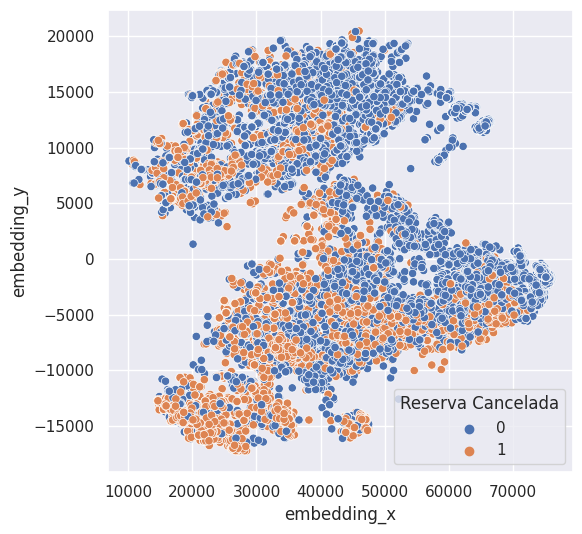

In [187]:
# SVD
reducer_emb = TruncatedSVD(n_components = 2, random_state = 42)

embedding = reducer_emb.fit_transform( df_leaf_emb )

# embedding
df_leaf_emb['embedding_x'] = embedding[: , 0]
df_leaf_emb['embedding_y'] = embedding[: , 1]

df_leaf_emb['Reserva Cancelada'] = data['Reserva Cancelada']

data2['embedding_x'] = embedding[: , 0]
data2['embedding_y'] = embedding[: , 1]

# Plot leaves
plt.figure(figsize=(6, 6))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',
                 data = df_leaf_emb,
                 hue = 'Reserva Cancelada');

## 2.2. Nationality

In [1]:
# spain = ['Spain']
# vet_1 = np.unique(['Andorra', 'Portugal', 'France', 'Gibraltar', 'Luxembourg', 'Belgium', 'Netherlands', 'Ireland', 'United Kingdom', 'Switzerland', 'Germany', 'Italy', 'Austria', 'Czech Republic', 'Denmark', 'Sweden', 'Norway', 'Poland', 'Slovakia', 'Hungary', 'Finland', 'Romania', 'Bulgaria', 'Turkey', 'Greece'])
# vet_2 = np.unique(['Russia', 'Ukraine', 'Belarus', 'Kuwait', 'Israel', 'Morocco', 'Tunisia', 'Cape Verde', 'Angola', 'Cyprus', 'Malta', 'Egypt', 'Libya', 'Iran, Islamic Republic of', 'Lebanon', 'Saudi Arabia', 'Jordan', 'Syrian Arab Republic', 'Iraq', 'United Arab Emirates', 'Oman', 'Qatar', 'Bahrain', 'Georgia', 'Armenia', 'Azerbaijan', 'Macedonia, the former Yugoslav Republic of', 'Albania', 'Serbia', 'Montenegro', 'Bosnia and Herzegovina', 'Croatia', 'Slovenia', 'Estonia', 'Latvia', 'Lithuania', 'Belarus', 'Uzbekistan', 'Kazakhstan'])
# vet_3 = np.unique(['China', 'Japan', 'South Korea', 'Taiwan', 'Hong Kong', 'Macao', 'Philippines', 'Viet Nam', 'Thailand', 'Malaysia', 'Singapore', 'Indonesia', 'India', 'Pakistan', 'Bangladesh', 'Nepal', 'Sri Lanka', 'Myanmar', 'Cambodia', 'Laos', 'Mongolia', 'North Korea'])
# vet_4 = np.unique(['United States', 'Canada', 'Mexico', 'Brazil', 'Argentina', 'Chile', 'Peru', 'Venezuela, Bolivarian Republic of', 'Colombia', 'Ecuador', 'Bolivia, Plurinational State of', 'Paraguay', 'Uruguay', 'Australia', 'New Zealand', 'Fiji', 'Papua New Guinea', 'Solomon Islands', 'Vanuatu', 'Samoa', 'Kiribati', 'Tonga', 'Micronesia, Federated States of', 'Marshall Islands', 'Palau', 'Tuvalu', 'Nauru', 'Cook Islands', 'Niue', 'Tokelau', 'Antarctica'])

# def country(x):
#     if x == 'Spain':
#         return 0
#     elif x in vet_1:
#         return 1
#     elif x in vet_2:
#         return 2
#     elif x in vet_3:
#         return 3
#     elif x in vet_4:
#         return 4
#     else:
#         return x
    
# data2['Nacionalidade'] = data2['Nacionalidade'].apply( country )

In [188]:
nac_continentes = pd.read_csv('../data/nac-conti.csv')
series_countries = dict(nac_continentes.set_index('Nacionalidade').squeeze())
series_countries['Spain'] = 'Spain'
data2['Nacionalidade'] = data2['Nacionalidade'].map(series_countries)
data2['Nacionalidade'] = data2['Nacionalidade'].apply(lambda x: 0 if x == "Spain" else 1 if x == 'África' else 2 if x == 'Ásia' else 3 if ((x == 'América do Sul') or (x == 'América Central')) else 4)

## 2.3. Tipo de quarto reservado

In [189]:
data2['Tipo do quarto reservado'].value_counts()

Amethyst         51778
Green Emerald    11798
Pink Sapphire     3924
Tanzanite         1782
Topaz             1245
Blue Sapphire      673
Red Ruby           573
Peridot            376
Garnet               8
Moonstone            2
Name: Tipo do quarto reservado, dtype: int64

In [190]:
room_types = ['Amethyst', 'Peridot', 'Garnet', 'Moonstone']

data2['Tipo do quarto reservado'] = data2['Tipo do quarto reservado'].apply(lambda x: 0 if x in room_types else 1)

# 3.0. Data Filtering

In [191]:
data3 = data2.copy()

In [192]:
data3.columns

Index(['id', 'Classificação do hotel', 'Meses da reserva até o check-in',
       'Número de pernoites reservadas', 'Número de hospedes',
       'Regime de alimentação', 'Nacionalidade', 'Forma de Reserva',
       'Já se hospedou anterioremente', 'Tipo do quarto reservado',
       'Reserva feita por agência de turismo', 'Reserva feita por empresa',
       'Reserva com Estacionamento', 'Reserva com Observações',
       'Reserva Cancelada', 'embedding_x', 'embedding_y'],
      dtype='object')

In [193]:
# Número de pernoites
data3['Número de pernoites reservadas'] = data3['Número de pernoites reservadas'].apply(lambda x: 21 if x > 21 else x)

In [194]:
# Número de hóspedes
data3['Número de hospedes'] = data3['Número de hospedes'].apply(lambda x: 5 if x > 5 else x)

# 4.0. Exploratory Data Analysis

In [195]:
data4 = data3.copy()

## 4.1. Univariate Analysis

In [ ]:
report = create_report(data4).show()

## 4.2. Bivatiate Analysis

### 4.2.1. Response Variable Relationship Analysis

In [ ]:
data4.columns

#### 4.2.1.1. Classificação do hotel x Reserva Cancelada

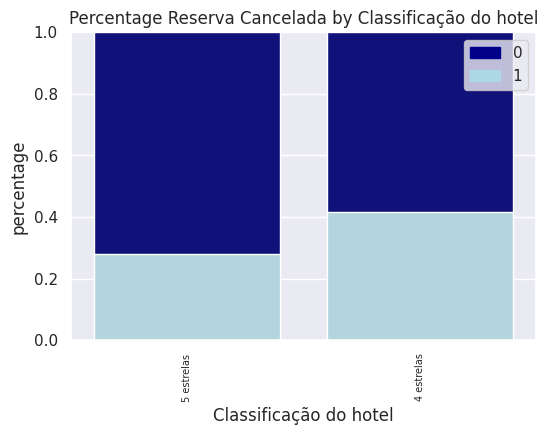

In [92]:
plot_barras_empilhadas(data4, 'Classificação do hotel', 'Reserva Cancelada', figsize = (6,4))

#### 4.2.1.2. Meses da reserva até o check-in x Reserva Cancelada

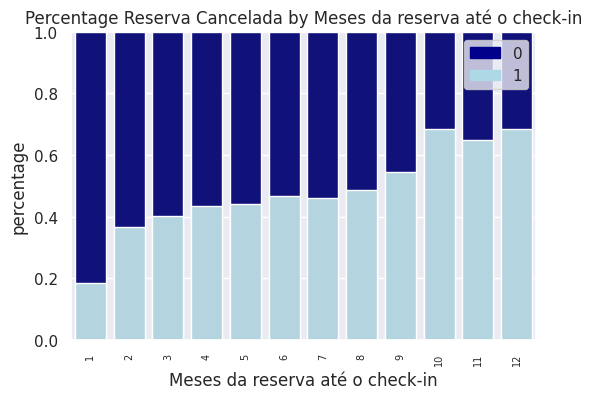

In [93]:
plot_barras_empilhadas(data4[data4['Meses da reserva até o check-in'] < 13], 'Meses da reserva até o check-in', 'Reserva Cancelada', figsize = (6,4))

#### 4.2.1.3. Número de pernoites reservadas x Reserva Cancelada

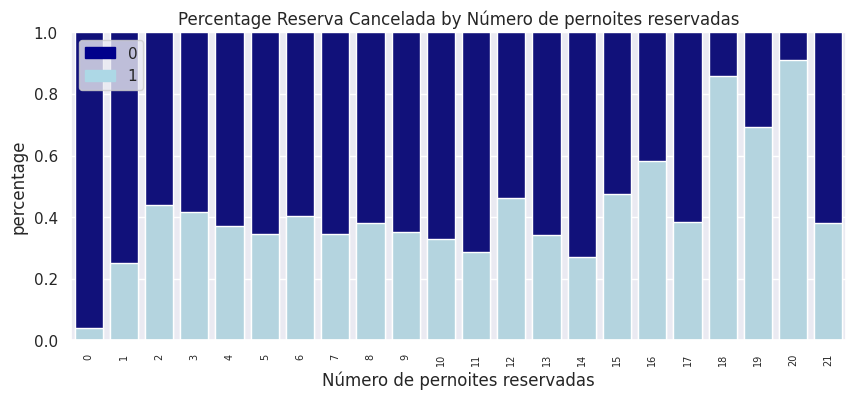

In [94]:
plot_barras_empilhadas(data4[data4['Número de pernoites reservadas'] < 22], 'Número de pernoites reservadas', 'Reserva Cancelada', figsize = (10,4))

#### 4.2.1.4. Número de hospedes x Reserva Cancelada

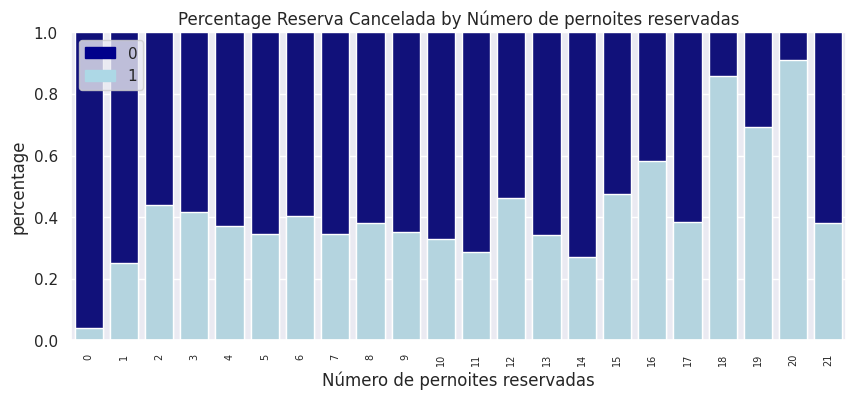

In [95]:
plot_barras_empilhadas(data4[data4['Número de pernoites reservadas'] < 22], 'Número de pernoites reservadas', 'Reserva Cancelada', figsize = (10,4))

#### 4.2.1.5. Regime de alimentação x Reserva Cancelada

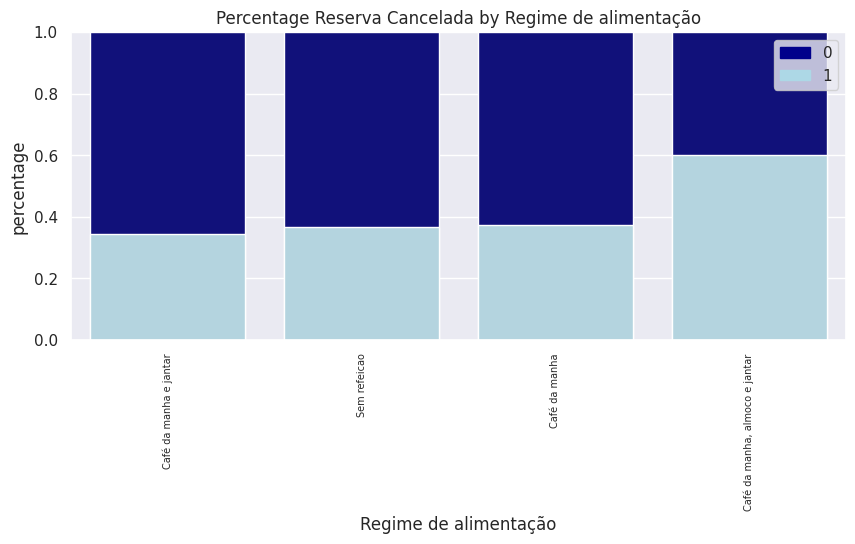

In [96]:
plot_barras_empilhadas(data4, 'Regime de alimentação', 'Reserva Cancelada', figsize = (10,4))

#### 4.2.1.6. Regime de alimentação x Reserva Cancelada

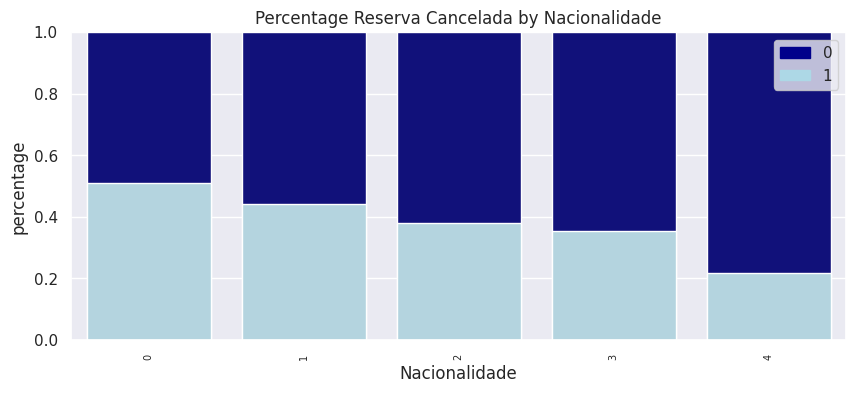

In [127]:
plot_barras_empilhadas(data4, 'Nacionalidade', 'Reserva Cancelada', figsize = (10,4))

#### 4.2.1.7 Tipo de quarto reservado

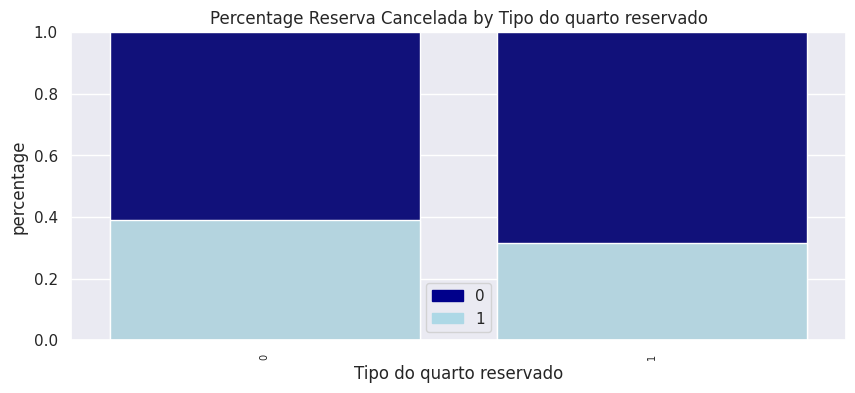

In [160]:
plot_barras_empilhadas(data4, 'Tipo do quarto reservado', 'Reserva Cancelada', figsize = (10,4))

In [130]:
data4['Tipo do quarto reservado'].value_counts()


room_types = ['Pink Sapphire', 'Tanzanite', 'Green Emerald', 'Red Ruby', 'Blue Sapphire']

Amethyst         51778
Green Emerald    11798
Pink Sapphire     3924
Tanzanite         1782
Topaz             1245
Blue Sapphire      673
Red Ruby           573
Peridot            376
Garnet               8
Moonstone            2
Name: Tipo do quarto reservado, dtype: int64

#### 4.2.1.8. Reserva com Observações

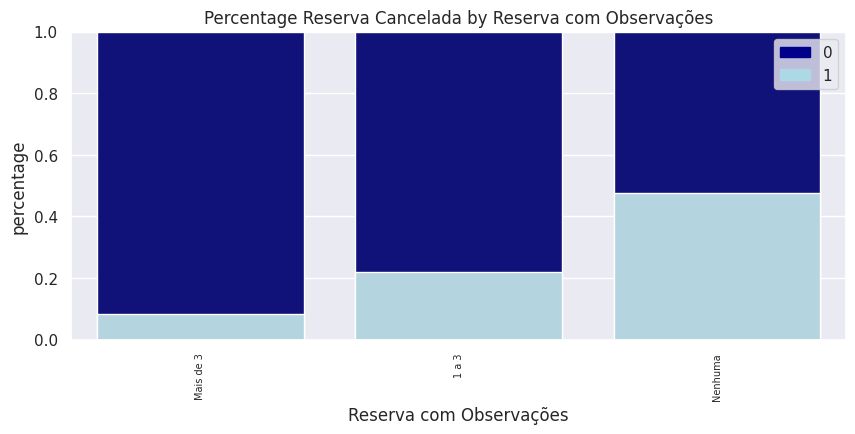

In [162]:
plot_barras_empilhadas(data4, 'Reserva com Observações', 'Reserva Cancelada', figsize = (10,4))

### 4.2.2. Other Variable Relationship Analysis

## 4.3. Multivariate Analysis

# 5.0. Data Preparation

In [196]:
data5 = data4.copy()

In [197]:
data5['Número de hospedes'] = data5['Número de hospedes'].astype('int32')
data5['Número de hospedes'] = data5['Número de hospedes'].apply(lambda x: 8 if x > 5 else x)

## 5.1. Standardization

## 5.2. Rescaling

In [198]:
rs_embedding_x = MinMaxScaler()
data5['embedding_x'] = rs_embedding_x.fit_transform(data5[['embedding_x']]) 

rs_embedding_y = MinMaxScaler()
data5['embedding_y'] = rs_embedding_y.fit_transform(data5[['embedding_y']]) 

## 5.3. Encoding

In [199]:
# Classificação do hotel
data5['Classificação do hotel'] = data5['Classificação do hotel'].apply(lambda x: int(x.replace(' estrelas','')))

In [200]:
# Regime de alimentação

data5['Regime de alimentação'].value_counts()
dicio_alimentacao = {'Sem refeicao':0,'Café da manha': 1,'Café da manha e jantar': 2,'Café da manha, almoco e jantar': 3}

data5['Regime de alimentação'] = data5['Regime de alimentação'].apply(lambda x: dicio_alimentacao[x])

In [201]:
# Nacionalidade
data5['Nacionalidade'] = data5['Nacionalidade'].apply(lambda x: 1 if x == "Spain" else 0)

# frequency_nationality = data5.groupby('Nacionalidade').size() / len( data )
# data5['Nacionalidade'] = data5['Nacionalidade'].apply(lambda x: frequency_nationality[x])

In [202]:
# Já se hospedou anterioremente
data5['Já se hospedou anterioremente'] = data5['Já se hospedou anterioremente'].apply(lambda x: 0 if x == "Não" else 1)

In [206]:
# Reserva com Observações
data5['Reserva com Observações'] = data5['Reserva com Observações'].apply(lambda x: 0 if x == "Nenhuma" else 1 if x == "1 a 3" else 2)

In [207]:
# Reserva com Estacionamento
data5['Reserva com Estacionamento'] = data5['Reserva com Estacionamento'].apply(lambda x: 0 if x == "Não" else 1)

In [208]:
# Reserva feita por agência de turismo
data5['Reserva feita por agência de turismo'] = data5['Reserva feita por agência de turismo'].apply(lambda x: 0 if x == "Não" else 1)

In [209]:
# Reserva feita por empresa
data5['Reserva feita por empresa'] = data5['Reserva feita por empresa'].apply(lambda x: 0 if x == "Não" else 1)

In [210]:
# Forma de Reserva
data5 = pd.get_dummies( data5, prefix=['reserva'], columns=['Forma de Reserva'] )

# 6.0. Feature Selection

In [211]:
data6 = data5.copy()

## 6.1. Manual Feature Selection

In [ ]:
data6.columns

In [ ]:
data6 = data6.drop(['Reserva feita por empresa','Reserva feita por agência de turismo','Classificação do hotel', 'Tipo do quarto reservado'], axis = 1)

In [ ]:
#plot_barras_empilhadas(data6,'reserva_B2B', 'Reserva Cancelada', figsize = (20,4))

## 6.2. Extra Trees Feature Selection

In [213]:
##### Extra trees ######
y = data6['Reserva Cancelada']
X = data6.drop(['Reserva Cancelada'], axis = 1)

# Model definition
extra_trees = ExtraTreesClassifier( n_estimators = 250, n_jobs = -1 )

# Training model
extra_trees.fit( X, y )

# Get feature importances
importances = extra_trees.feature_importances_

# Load std of estimators feature importances
std_importances = np.std( [tree.feature_importances_ for tree in extra_trees.estimators_], axis = 0 )

# Sort list of feature importance
indices_importances = np.argsort( importances )[::-1]

# Print feature ranking
print('Feature Ranking: ')
df = pd.DataFrame()
for i, j in zip(X, extra_trees.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index = [0])
    df = pd.concat( [ df, aux], axis = 0 )
    df = df.sort_values( 'importance', ascending = False ) 
print( df )

Feature Ranking: 
                                feature  importance
0                                    id    0.337714
0                           embedding_y    0.230297
0                           embedding_x    0.219334
0                Classificação do hotel    0.038421
0               Reserva com Observações    0.032757
0        Número de pernoites reservadas    0.028617
0       Meses da reserva até o check-in    0.027263
0                    Número de hospedes    0.019390
0                 Regime de alimentação    0.017412
0                       reserva_Agência    0.013932
0              Tipo do quarto reservado    0.008681
0                        reserva_Balcão    0.007568
0  Reserva feita por agência de turismo    0.007017
0             Reserva feita por empresa    0.005047
0         Já se hospedou anterioremente    0.004040
0                           reserva_B2B    0.002510
0                         Nacionalidade    0.000000
0            Reserva com Estacionamento    0.0

In [ ]:
# Plot impurity-based feature importances of the forest
plt.figure(figsize = (6, 4) )
plt.title('Feature Importances')
plt.bar( range (X.shape[1]), importances[indices_importances], 
         color = "r", yerr = std_importances[indices_importances], align = "center")
plt.xticks( range( X.shape[1]), df['feature'].values, rotation = 90 )
plt.xlim( [ -1, X.shape[1] ] )
plt.show()

## 6.3. Final feature Selection

# 7.0. Machine Learning Modelling

In [ ]:
data7 = data6.copy()

In [215]:
y = data['Reserva Cancelada']
X = data.drop('Reserva Cancelada', axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )

X_train, X_test = preprocessing( X_train, X_test, y_train )

## 7.1. Models

### 7.1.1. XGBoost

#### 7.1.1.1. Model Definition

In [216]:
# Definição modelo
xgb_model = XGBClassifier(n_estimators = 500, max_depth = 6, random_state = 42)

cross_val( X, y, xgb_model, limiar = 0.5, cv = 10, verbose = True)

# # Treino
# xgb_model.fit(X_train, y_train)

# # Predictions
# xgb_probas = xgb_model.predict_proba(X_test)
# xgb_probas = xgb_probas.T[1]

0.960401667298219


KeyboardInterrupt: 

In [ ]:
limiares  = np.arange(0,1, 0.01)

xgb_scores = []

for limiar in limiares:
    predictions = []
    
    for proba in xgb_probas:
        if proba > limiar:
            predictions.append(1)
        else:
            predictions.append(0)
            
    f1 = metrics.f1_score(y_test, predictions)
    
    xgb_scores.append(f1)

#### 7.1.1.2. Model Evaluation

In [ ]:
plt.figure(figsize = (8,5))
sns.lineplot(x = limiares, y = xgb_scores);

In [ ]:
xgb_predictions = []
limiar = 0.5

for proba in xgb_probas:
    if proba > limiar:
        xgb_predictions.append(1)
    else:
        xgb_predictions.append(0)

In [ ]:
confusion_matrix(y_test, xgb_predictions)

In [ ]:
metrics.f1_score(y_test, xgb_predictions)

### 7.1.2. LightGBM

#### 7.1.2.1. Model Definition

In [ ]:
# Define model
lgbm_model = lgb.LGBMClassifier(n_estimators = 500,
                                max_depth = 6,
                                boosting_type= 'gbdt',
                                objective = 'binary',
                                metric = 'binary_logloss'
                                )

# Treino
lgbm_model.fit(X_train, y_train)

# Predictions
lgbm_probas = lgbm_model.predict_proba(X_test)
lgbm_probas = lgbm_probas.T[1]

#### 7.1.2.2. Model Evaluation

In [ ]:
limiares  = np.arange(0,1, 0.01)

lgbm_scores = []

for limiar in limiares:
    predictions = []
    
    for proba in lgbm_probas:
        if proba > limiar:
            predictions.append(1)
        else:
            predictions.append(0)
            
    f1 = metrics.f1_score(y_test, predictions)
    
    lgbm_scores.append(f1)

In [ ]:
plt.figure(figsize = (8,5))
sns.lineplot(x = limiares, y = lgbm_scores);

In [ ]:
lgbm_predictions = []
limiar = 0.56

for proba in lgbm_probas:
    if proba > limiar:
        lgbm_predictions.append(1)
    else:
        lgbm_predictions.append(0)

In [ ]:
metrics.f1_score(y_test, lgbm_predictions)

### 7.1.3. CatBoost

#### 7.1.2.1. Model Definition

In [168]:
# Define model
catboost_model = cb.CatBoostClassifier(
                n_estimators=500,
                max_depth=10,
                learning_rate=0.1
            )

# Treino
cross_val( X, y, catboost_model, limiar = 0.5, cv = 10, verbose = True)

0:	learn: 0.5683506	total: 109ms	remaining: 54.4s
1:	learn: 0.4820807	total: 238ms	remaining: 59.3s
2:	learn: 0.4304537	total: 238ms	remaining: 59.3s
3:	learn: 0.3943259	total: 525ms	remaining: 1m 26s
4:	learn: 0.3668136	total: 660ms	remaining: 1m 21s
5:	learn: 0.3432921	total: 753ms	remaining: 1m 14s
6:	learn: 0.3263215	total: 866ms	remaining: 1m 11s
7:	learn: 0.3102262	total: 957ms	remaining: 1m 7s
8:	learn: 0.2964723	total: 1.05s	remaining: 1m 4s
9:	learn: 0.2871998	total: 1.17s	remaining: 1m 3s
10:	learn: 0.2785734	total: 1.27s	remaining: 1m 2s
11:	learn: 0.2708181	total: 1.39s	remaining: 1m 1s
12:	learn: 0.2657003	total: 1.5s	remaining: 1m 1s
13:	learn: 0.2606543	total: 1.6s	remaining: 59.8s
14:	learn: 0.2562710	total: 1.69s	remaining: 58.5s
15:	learn: 0.2506055	total: 1.77s	remaining: 57.1s
16:	learn: 0.2470745	total: 1.85s	remaining: 55.8s
17:	learn: 0.2427745	total: 1.94s	remaining: 54.9s
18:	learn: 0.2393004	total: 2.01s	remaining: 53.7s
19:	learn: 0.2368775	total: 2.09s	remai

162:	learn: 0.1279742	total: 17s	remaining: 37.9s
163:	learn: 0.1278083	total: 17.1s	remaining: 37.7s
164:	learn: 0.1274687	total: 17.2s	remaining: 37.6s
165:	learn: 0.1270224	total: 17.3s	remaining: 37.4s
166:	learn: 0.1268111	total: 17.3s	remaining: 37.2s
167:	learn: 0.1265761	total: 17.4s	remaining: 37.1s
168:	learn: 0.1260831	total: 17.6s	remaining: 37s
169:	learn: 0.1258900	total: 17.7s	remaining: 36.9s
170:	learn: 0.1256915	total: 17.8s	remaining: 36.8s
171:	learn: 0.1254282	total: 17.9s	remaining: 36.7s
172:	learn: 0.1251615	total: 18s	remaining: 36.6s
173:	learn: 0.1248921	total: 18s	remaining: 36.6s
174:	learn: 0.1245527	total: 18.3s	remaining: 36.7s
175:	learn: 0.1243444	total: 18.3s	remaining: 36.7s
176:	learn: 0.1240654	total: 18.3s	remaining: 36.3s
177:	learn: 0.1238297	total: 18.6s	remaining: 36.5s
178:	learn: 0.1235466	total: 18.7s	remaining: 36.3s
179:	learn: 0.1232903	total: 18.8s	remaining: 36.2s
180:	learn: 0.1230676	total: 18.9s	remaining: 36s
181:	learn: 0.1229049	

322:	learn: 0.0972244	total: 33.3s	remaining: 20s
323:	learn: 0.0970854	total: 33.4s	remaining: 19.8s
324:	learn: 0.0969369	total: 33.5s	remaining: 19.7s
325:	learn: 0.0968387	total: 33.6s	remaining: 19.6s
326:	learn: 0.0967337	total: 33.7s	remaining: 19.5s
327:	learn: 0.0965586	total: 33.7s	remaining: 19.5s
328:	learn: 0.0964127	total: 33.9s	remaining: 19.3s
329:	learn: 0.0961698	total: 34s	remaining: 19.2s
330:	learn: 0.0960327	total: 34.1s	remaining: 19.1s
331:	learn: 0.0959096	total: 34.3s	remaining: 19s
332:	learn: 0.0958065	total: 34.3s	remaining: 19s
333:	learn: 0.0956356	total: 34.5s	remaining: 18.9s
334:	learn: 0.0955187	total: 34.6s	remaining: 18.7s
335:	learn: 0.0953888	total: 34.7s	remaining: 18.6s
336:	learn: 0.0952581	total: 34.8s	remaining: 18.5s
337:	learn: 0.0951306	total: 34.9s	remaining: 18.3s
338:	learn: 0.0950459	total: 35s	remaining: 18.2s
339:	learn: 0.0950103	total: 35.1s	remaining: 18.1s
340:	learn: 0.0948676	total: 35.1s	remaining: 18s
341:	learn: 0.0946722	to

481:	learn: 0.0800633	total: 50.6s	remaining: 2.08s
482:	learn: 0.0799873	total: 50.8s	remaining: 1.97s
483:	learn: 0.0799423	total: 50.9s	remaining: 1.85s
484:	learn: 0.0798555	total: 51s	remaining: 1.74s
485:	learn: 0.0797979	total: 51.1s	remaining: 1.62s
486:	learn: 0.0797121	total: 51.3s	remaining: 1.51s
487:	learn: 0.0796468	total: 51.3s	remaining: 1.51s
488:	learn: 0.0795894	total: 51.5s	remaining: 1.28s
489:	learn: 0.0794942	total: 51.6s	remaining: 1.16s
490:	learn: 0.0793990	total: 51.7s	remaining: 1.05s
491:	learn: 0.0793133	total: 51.8s	remaining: 930ms
492:	learn: 0.0791447	total: 51.9s	remaining: 813ms
493:	learn: 0.0790470	total: 52s	remaining: 696ms
494:	learn: 0.0789756	total: 52.1s	remaining: 580ms
495:	learn: 0.0788929	total: 52.2s	remaining: 464ms
496:	learn: 0.0788375	total: 52.3s	remaining: 348ms
497:	learn: 0.0787353	total: 52.4s	remaining: 232ms
498:	learn: 0.0786357	total: 52.5s	remaining: 116ms
499:	learn: 0.0785708	total: 52.5s	remaining: 116ms
0.93884358784284

142:	learn: 0.1375153	total: 13.9s	remaining: 37.9s
143:	learn: 0.1370634	total: 14.1s	remaining: 38.1s
144:	learn: 0.1369062	total: 14.3s	remaining: 38.1s
145:	learn: 0.1366630	total: 14.4s	remaining: 37.9s
146:	learn: 0.1363945	total: 14.5s	remaining: 37.9s
147:	learn: 0.1359796	total: 14.6s	remaining: 37.9s
148:	learn: 0.1356265	total: 14.8s	remaining: 37.8s
149:	learn: 0.1353091	total: 14.9s	remaining: 37.7s
150:	learn: 0.1350185	total: 15s	remaining: 37.6s
151:	learn: 0.1345943	total: 15s	remaining: 37.6s
152:	learn: 0.1342286	total: 15.2s	remaining: 37.7s
153:	learn: 0.1339537	total: 15.3s	remaining: 37.6s
154:	learn: 0.1336093	total: 15.4s	remaining: 37.5s
155:	learn: 0.1333670	total: 15.5s	remaining: 37.3s
156:	learn: 0.1330521	total: 15.6s	remaining: 37.2s
157:	learn: 0.1328072	total: 15.7s	remaining: 37.1s
158:	learn: 0.1323897	total: 15.8s	remaining: 37s
159:	learn: 0.1319300	total: 15.9s	remaining: 36.8s
160:	learn: 0.1314954	total: 16s	remaining: 36.6s
161:	learn: 0.131173

303:	learn: 0.1019633	total: 29.4s	remaining: 20.5s
304:	learn: 0.1018073	total: 29.4s	remaining: 20.5s
305:	learn: 0.1017429	total: 29.6s	remaining: 20.4s
306:	learn: 0.1016608	total: 29.6s	remaining: 20.4s
307:	learn: 0.1014963	total: 29.9s	remaining: 20.3s
308:	learn: 0.1014151	total: 30s	remaining: 20.2s
309:	learn: 0.1012797	total: 30.1s	remaining: 20.1s
310:	learn: 0.1011769	total: 30.2s	remaining: 19.9s
311:	learn: 0.1010890	total: 30.3s	remaining: 19.9s
312:	learn: 0.1009629	total: 30.4s	remaining: 19.7s
313:	learn: 0.1008731	total: 30.4s	remaining: 19.7s
314:	learn: 0.1007373	total: 30.6s	remaining: 19.6s
315:	learn: 0.1005866	total: 30.8s	remaining: 19.5s
316:	learn: 0.1004100	total: 30.8s	remaining: 19.4s
317:	learn: 0.1003411	total: 30.8s	remaining: 19.4s
318:	learn: 0.1001478	total: 31.1s	remaining: 19.3s
319:	learn: 0.0999596	total: 31.2s	remaining: 19.2s
320:	learn: 0.0998615	total: 31.3s	remaining: 19s
321:	learn: 0.0998011	total: 31.4s	remaining: 18.9s
322:	learn: 0.09

462:	learn: 0.0839012	total: 46.9s	remaining: 4.05s
463:	learn: 0.0838435	total: 47s	remaining: 3.94s
464:	learn: 0.0837899	total: 47.2s	remaining: 3.83s
465:	learn: 0.0837113	total: 47.3s	remaining: 3.72s
466:	learn: 0.0836542	total: 47.4s	remaining: 3.61s
467:	learn: 0.0835392	total: 47.5s	remaining: 3.5s
468:	learn: 0.0834228	total: 47.6s	remaining: 3.39s
469:	learn: 0.0833680	total: 47.8s	remaining: 3.29s
470:	learn: 0.0833001	total: 47.9s	remaining: 3.18s
471:	learn: 0.0832045	total: 48s	remaining: 3.07s
472:	learn: 0.0831231	total: 48.2s	remaining: 2.96s
473:	learn: 0.0830199	total: 48.3s	remaining: 2.85s
474:	learn: 0.0829293	total: 48.4s	remaining: 2.75s
475:	learn: 0.0828752	total: 48.5s	remaining: 2.64s
476:	learn: 0.0828209	total: 48.6s	remaining: 2.52s
477:	learn: 0.0827683	total: 48.8s	remaining: 2.42s
478:	learn: 0.0826568	total: 48.9s	remaining: 2.31s
479:	learn: 0.0825364	total: 49s	remaining: 2.2s
480:	learn: 0.0824698	total: 49.1s	remaining: 2.09s
481:	learn: 0.082378

123:	learn: 0.1330472	total: 13.7s	remaining: 44.1s
124:	learn: 0.1325672	total: 13.8s	remaining: 44s
125:	learn: 0.1319317	total: 13.9s	remaining: 43.7s
126:	learn: 0.1314465	total: 14s	remaining: 43.5s
127:	learn: 0.1311869	total: 14.1s	remaining: 43.4s
128:	learn: 0.1308865	total: 14.1s	remaining: 43.4s
129:	learn: 0.1303903	total: 14.4s	remaining: 43.7s
130:	learn: 0.1300750	total: 14.5s	remaining: 43.4s
131:	learn: 0.1296496	total: 14.6s	remaining: 43.2s
132:	learn: 0.1292965	total: 14.7s	remaining: 43s
133:	learn: 0.1285956	total: 14.8s	remaining: 42.9s
134:	learn: 0.1284022	total: 14.8s	remaining: 42.9s
135:	learn: 0.1279798	total: 15.1s	remaining: 43.1s
136:	learn: 0.1276537	total: 15.2s	remaining: 43s
137:	learn: 0.1272412	total: 15.3s	remaining: 42.8s
138:	learn: 0.1267581	total: 15.4s	remaining: 42.7s
139:	learn: 0.1263012	total: 15.5s	remaining: 42.5s
140:	learn: 0.1260647	total: 15.6s	remaining: 42.5s
141:	learn: 0.1258112	total: 15.6s	remaining: 42.5s
142:	learn: 0.125692

283:	learn: 0.0951006	total: 32.9s	remaining: 28.2s
284:	learn: 0.0949062	total: 33s	remaining: 28s
285:	learn: 0.0947815	total: 33.1s	remaining: 27.9s
286:	learn: 0.0946875	total: 33.2s	remaining: 27.8s
287:	learn: 0.0945536	total: 33.2s	remaining: 27.8s
288:	learn: 0.0944288	total: 33.5s	remaining: 27.6s
289:	learn: 0.0942480	total: 33.5s	remaining: 27.6s
290:	learn: 0.0940942	total: 33.8s	remaining: 27.5s
291:	learn: 0.0940115	total: 33.9s	remaining: 27.3s
292:	learn: 0.0937981	total: 33.9s	remaining: 27.3s
293:	learn: 0.0935968	total: 34.2s	remaining: 27.2s
294:	learn: 0.0934712	total: 34.2s	remaining: 27.2s
295:	learn: 0.0932860	total: 34.4s	remaining: 27s
296:	learn: 0.0930819	total: 34.6s	remaining: 26.9s
297:	learn: 0.0929244	total: 34.7s	remaining: 26.8s
298:	learn: 0.0928329	total: 34.9s	remaining: 26.6s
299:	learn: 0.0927644	total: 34.9s	remaining: 26.6s
300:	learn: 0.0926794	total: 35s	remaining: 26.4s
301:	learn: 0.0925702	total: 35.3s	remaining: 26.4s
302:	learn: 0.092432

442:	learn: 0.0775925	total: 52.3s	remaining: 7.56s
443:	learn: 0.0774872	total: 52.3s	remaining: 7.56s
444:	learn: 0.0774007	total: 52.5s	remaining: 7.32s
445:	learn: 0.0773198	total: 52.5s	remaining: 7.32s
446:	learn: 0.0772251	total: 52.8s	remaining: 7.07s
447:	learn: 0.0770955	total: 52.9s	remaining: 6.93s
448:	learn: 0.0770381	total: 53s	remaining: 6.8s
449:	learn: 0.0769945	total: 53.2s	remaining: 6.66s
450:	learn: 0.0768606	total: 53.2s	remaining: 6.52s
451:	learn: 0.0767471	total: 53.4s	remaining: 6.39s
452:	learn: 0.0766235	total: 53.5s	remaining: 6.25s
453:	learn: 0.0765712	total: 53.6s	remaining: 6.12s
454:	learn: 0.0764979	total: 53.7s	remaining: 5.98s
455:	learn: 0.0763909	total: 53.9s	remaining: 5.85s
456:	learn: 0.0763348	total: 54s	remaining: 5.72s
457:	learn: 0.0762753	total: 54.1s	remaining: 5.58s
458:	learn: 0.0761979	total: 54.2s	remaining: 5.45s
459:	learn: 0.0761089	total: 54.3s	remaining: 5.31s
460:	learn: 0.0760255	total: 54.5s	remaining: 5.18s
461:	learn: 0.075

103:	learn: 0.1569834	total: 12.1s	remaining: 51.4s
104:	learn: 0.1563433	total: 12.2s	remaining: 51.4s
105:	learn: 0.1557272	total: 12.2s	remaining: 51.4s
106:	learn: 0.1551850	total: 12.5s	remaining: 51.7s
107:	learn: 0.1547365	total: 12.6s	remaining: 51.4s
108:	learn: 0.1542236	total: 12.7s	remaining: 51.1s
109:	learn: 0.1538414	total: 12.8s	remaining: 50.9s
110:	learn: 0.1533584	total: 12.9s	remaining: 50.6s
111:	learn: 0.1528483	total: 13s	remaining: 50.5s
112:	learn: 0.1521772	total: 13.1s	remaining: 50.2s
113:	learn: 0.1516651	total: 13.1s	remaining: 50.2s
114:	learn: 0.1512439	total: 13.3s	remaining: 50.4s
115:	learn: 0.1506670	total: 13.5s	remaining: 50.2s
116:	learn: 0.1502845	total: 13.5s	remaining: 50.2s
117:	learn: 0.1499076	total: 13.7s	remaining: 50.4s
118:	learn: 0.1491666	total: 13.8s	remaining: 50.1s
119:	learn: 0.1486187	total: 13.9s	remaining: 50s
120:	learn: 0.1481574	total: 14.1s	remaining: 49.8s
121:	learn: 0.1478864	total: 14.2s	remaining: 49.6s
122:	learn: 0.14

263:	learn: 0.1108049	total: 31s	remaining: 31s
264:	learn: 0.1105678	total: 31.2s	remaining: 30.9s
265:	learn: 0.1104268	total: 31.3s	remaining: 30.7s
266:	learn: 0.1103701	total: 31.4s	remaining: 30.6s
267:	learn: 0.1102466	total: 31.5s	remaining: 30.5s
268:	learn: 0.1101335	total: 31.6s	remaining: 30.3s
269:	learn: 0.1098629	total: 31.7s	remaining: 30.1s
270:	learn: 0.1096965	total: 31.8s	remaining: 30s
271:	learn: 0.1094939	total: 31.9s	remaining: 29.8s
272:	learn: 0.1093196	total: 32s	remaining: 29.7s
273:	learn: 0.1091019	total: 32.1s	remaining: 29.5s
274:	learn: 0.1089266	total: 32.2s	remaining: 29.4s
275:	learn: 0.1088111	total: 32.3s	remaining: 29.2s
276:	learn: 0.1087065	total: 32.4s	remaining: 29s
277:	learn: 0.1085541	total: 32.5s	remaining: 28.9s
278:	learn: 0.1083939	total: 32.6s	remaining: 28.7s
279:	learn: 0.1082620	total: 32.7s	remaining: 28.6s
280:	learn: 0.1081364	total: 32.8s	remaining: 28.4s
281:	learn: 0.1079384	total: 32.9s	remaining: 28.3s
282:	learn: 0.1077754	

422:	learn: 0.0909170	total: 48.4s	remaining: 9.62s
423:	learn: 0.0907906	total: 48.5s	remaining: 9.49s
424:	learn: 0.0906793	total: 48.6s	remaining: 9.37s
425:	learn: 0.0906221	total: 48.7s	remaining: 9.24s
426:	learn: 0.0905124	total: 48.8s	remaining: 9.12s
427:	learn: 0.0904479	total: 48.9s	remaining: 8.98s
428:	learn: 0.0903802	total: 49s	remaining: 8.86s
429:	learn: 0.0902617	total: 49.2s	remaining: 8.73s
430:	learn: 0.0901203	total: 49.3s	remaining: 8.62s
431:	learn: 0.0899985	total: 49.5s	remaining: 8.49s
432:	learn: 0.0899141	total: 49.5s	remaining: 8.36s
433:	learn: 0.0898501	total: 49.7s	remaining: 8.24s
434:	learn: 0.0897683	total: 49.8s	remaining: 8.11s
435:	learn: 0.0897038	total: 49.8s	remaining: 8.11s
436:	learn: 0.0896253	total: 50.1s	remaining: 7.89s
437:	learn: 0.0895470	total: 50.2s	remaining: 7.76s
438:	learn: 0.0894309	total: 50.3s	remaining: 7.63s
439:	learn: 0.0893047	total: 50.4s	remaining: 7.5s
440:	learn: 0.0891864	total: 50.5s	remaining: 7.37s
441:	learn: 0.0

84:	learn: 0.1553521	total: 9.08s	remaining: 48.3s
85:	learn: 0.1547841	total: 9.18s	remaining: 48.1s
86:	learn: 0.1541729	total: 9.28s	remaining: 47.9s
87:	learn: 0.1535381	total: 9.28s	remaining: 47.9s
88:	learn: 0.1525676	total: 9.39s	remaining: 47.6s
89:	learn: 0.1521038	total: 9.48s	remaining: 47.4s
90:	learn: 0.1517115	total: 9.72s	remaining: 47.9s
91:	learn: 0.1508153	total: 9.83s	remaining: 47.7s
92:	learn: 0.1505314	total: 9.91s	remaining: 47.5s
93:	learn: 0.1501198	total: 10s	remaining: 47.3s
94:	learn: 0.1497573	total: 10.1s	remaining: 47.1s
95:	learn: 0.1492800	total: 10.2s	remaining: 47s
96:	learn: 0.1487216	total: 10.4s	remaining: 46.9s
97:	learn: 0.1481898	total: 10.4s	remaining: 46.6s
98:	learn: 0.1478257	total: 10.5s	remaining: 46.4s
99:	learn: 0.1474364	total: 10.6s	remaining: 46.2s
100:	learn: 0.1468032	total: 10.7s	remaining: 46s
101:	learn: 0.1463962	total: 10.8s	remaining: 45.7s
102:	learn: 0.1458595	total: 10.9s	remaining: 45.5s
103:	learn: 0.1454365	total: 11s	r

244:	learn: 0.1036956	total: 26.8s	remaining: 30.9s
245:	learn: 0.1035740	total: 27.1s	remaining: 30.8s
246:	learn: 0.1033214	total: 27.1s	remaining: 30.8s
247:	learn: 0.1031143	total: 27.2s	remaining: 30.6s
248:	learn: 0.1028637	total: 27.4s	remaining: 30.6s
249:	learn: 0.1027301	total: 27.5s	remaining: 30.4s
250:	learn: 0.1026073	total: 27.6s	remaining: 30.3s
251:	learn: 0.1024892	total: 27.8s	remaining: 30.2s
252:	learn: 0.1021947	total: 27.9s	remaining: 30s
253:	learn: 0.1020474	total: 28s	remaining: 29.9s
254:	learn: 0.1019371	total: 28.1s	remaining: 29.8s
255:	learn: 0.1018003	total: 28.2s	remaining: 29.6s
256:	learn: 0.1017294	total: 28.2s	remaining: 29.5s
257:	learn: 0.1015824	total: 28.3s	remaining: 29.3s
258:	learn: 0.1013227	total: 28.5s	remaining: 29.2s
259:	learn: 0.1012489	total: 28.6s	remaining: 29.1s
260:	learn: 0.1010338	total: 28.7s	remaining: 28.9s
261:	learn: 0.1008360	total: 28.8s	remaining: 28.8s
262:	learn: 0.1005963	total: 28.9s	remaining: 28.7s
263:	learn: 0.10

403:	learn: 0.0833962	total: 43.9s	remaining: 11.5s
404:	learn: 0.0832862	total: 44s	remaining: 11.4s
405:	learn: 0.0831571	total: 44.1s	remaining: 11.2s
406:	learn: 0.0830937	total: 44.2s	remaining: 11.1s
407:	learn: 0.0830563	total: 44.3s	remaining: 11s
408:	learn: 0.0829601	total: 44.3s	remaining: 11s
409:	learn: 0.0828543	total: 44.6s	remaining: 10.8s
410:	learn: 0.0827082	total: 44.7s	remaining: 10.7s
411:	learn: 0.0826536	total: 44.8s	remaining: 10.5s
412:	learn: 0.0825891	total: 44.9s	remaining: 10.4s
413:	learn: 0.0824549	total: 45s	remaining: 10.3s
414:	learn: 0.0823927	total: 45.1s	remaining: 10.2s
415:	learn: 0.0823031	total: 45.1s	remaining: 10.2s
416:	learn: 0.0822451	total: 45.4s	remaining: 9.96s
417:	learn: 0.0821951	total: 45.5s	remaining: 9.84s
418:	learn: 0.0820985	total: 45.6s	remaining: 9.71s
419:	learn: 0.0820359	total: 45.7s	remaining: 9.59s
420:	learn: 0.0819748	total: 45.7s	remaining: 9.46s
421:	learn: 0.0818738	total: 45.9s	remaining: 9.34s
422:	learn: 0.081761

66:	learn: 0.1688318	total: 7.38s	remaining: 56s
67:	learn: 0.1681120	total: 7.48s	remaining: 55.7s
68:	learn: 0.1679224	total: 7.56s	remaining: 55.2s
69:	learn: 0.1669557	total: 7.69s	remaining: 55.1s
70:	learn: 0.1665387	total: 7.79s	remaining: 54.8s
71:	learn: 0.1654946	total: 7.91s	remaining: 54.6s
72:	learn: 0.1648203	total: 7.98s	remaining: 54.1s
73:	learn: 0.1642578	total: 8.08s	remaining: 53.8s
74:	learn: 0.1636308	total: 8.08s	remaining: 53.8s
75:	learn: 0.1626642	total: 8.36s	remaining: 54.5s
76:	learn: 0.1618865	total: 8.44s	remaining: 54.1s
77:	learn: 0.1609668	total: 8.44s	remaining: 54.1s
78:	learn: 0.1602554	total: 8.7s	remaining: 54.7s
79:	learn: 0.1598626	total: 8.8s	remaining: 54.4s
80:	learn: 0.1593288	total: 8.89s	remaining: 54s
81:	learn: 0.1589069	total: 9s	remaining: 53.8s
82:	learn: 0.1581335	total: 9.09s	remaining: 53.4s
83:	learn: 0.1573447	total: 9.19s	remaining: 53.1s
84:	learn: 0.1569016	total: 9.29s	remaining: 52.8s
85:	learn: 0.1564690	total: 9.37s	remain

226:	learn: 0.1089193	total: 24.5s	remaining: 33.6s
227:	learn: 0.1086348	total: 24.6s	remaining: 33.5s
228:	learn: 0.1082033	total: 24.7s	remaining: 33.3s
229:	learn: 0.1080601	total: 24.8s	remaining: 33.1s
230:	learn: 0.1077389	total: 24.8s	remaining: 33.1s
231:	learn: 0.1075121	total: 25.1s	remaining: 33.1s
232:	learn: 0.1072796	total: 25.2s	remaining: 32.9s
233:	learn: 0.1071234	total: 25.2s	remaining: 32.8s
234:	learn: 0.1070631	total: 25.2s	remaining: 32.8s
235:	learn: 0.1068771	total: 25.5s	remaining: 32.7s
236:	learn: 0.1067153	total: 25.6s	remaining: 32.5s
237:	learn: 0.1064596	total: 25.7s	remaining: 32.4s
238:	learn: 0.1062432	total: 25.8s	remaining: 32.2s
239:	learn: 0.1061081	total: 25.9s	remaining: 32.1s
240:	learn: 0.1058910	total: 25.9s	remaining: 32.1s
241:	learn: 0.1057615	total: 26.2s	remaining: 32s
242:	learn: 0.1055811	total: 26.3s	remaining: 31.8s
243:	learn: 0.1054703	total: 26.4s	remaining: 31.7s
244:	learn: 0.1053719	total: 26.4s	remaining: 31.5s
245:	learn: 0.

385:	learn: 0.0866471	total: 41.6s	remaining: 14s
386:	learn: 0.0865929	total: 41.7s	remaining: 13.8s
387:	learn: 0.0864790	total: 41.8s	remaining: 13.7s
388:	learn: 0.0863618	total: 41.9s	remaining: 13.6s
389:	learn: 0.0862570	total: 42s	remaining: 13.4s
390:	learn: 0.0861744	total: 42.1s	remaining: 13.3s
391:	learn: 0.0861460	total: 42.2s	remaining: 13.2s
392:	learn: 0.0860486	total: 42.3s	remaining: 13.1s
393:	learn: 0.0859422	total: 42.4s	remaining: 12.9s
394:	learn: 0.0858453	total: 42.5s	remaining: 12.8s
395:	learn: 0.0857333	total: 42.6s	remaining: 12.7s
396:	learn: 0.0856569	total: 42.7s	remaining: 12.5s
397:	learn: 0.0855296	total: 42.8s	remaining: 12.4s
398:	learn: 0.0853733	total: 42.8s	remaining: 12.4s
399:	learn: 0.0853402	total: 42.9s	remaining: 12.2s
400:	learn: 0.0852712	total: 43.2s	remaining: 12.1s
401:	learn: 0.0852180	total: 43.3s	remaining: 12s
402:	learn: 0.0851643	total: 43.4s	remaining: 11.8s
403:	learn: 0.0850795	total: 43.5s	remaining: 11.7s
404:	learn: 0.0849

46:	learn: 0.1836555	total: 5.29s	remaining: 1m 1s
47:	learn: 0.1824662	total: 5.42s	remaining: 1m 1s
48:	learn: 0.1818180	total: 5.5s	remaining: 1m
49:	learn: 0.1808504	total: 5.62s	remaining: 1m
50:	learn: 0.1800993	total: 5.73s	remaining: 59.8s
51:	learn: 0.1794197	total: 5.73s	remaining: 59.8s
52:	learn: 0.1785569	total: 5.83s	remaining: 59.2s
53:	learn: 0.1773379	total: 6.1s	remaining: 1m
54:	learn: 0.1766831	total: 6.2s	remaining: 59.9s
55:	learn: 0.1760386	total: 6.3s	remaining: 59.6s
56:	learn: 0.1749449	total: 6.42s	remaining: 59.3s
57:	learn: 0.1741686	total: 6.51s	remaining: 58.8s
58:	learn: 0.1734858	total: 6.63s	remaining: 58.5s
59:	learn: 0.1726291	total: 6.75s	remaining: 58.2s
60:	learn: 0.1719243	total: 6.75s	remaining: 58.2s
61:	learn: 0.1710778	total: 7s	remaining: 59s
62:	learn: 0.1703827	total: 7.11s	remaining: 58.6s
63:	learn: 0.1697253	total: 7.2s	remaining: 58.1s
64:	learn: 0.1687349	total: 7.2s	remaining: 58.1s
65:	learn: 0.1678396	total: 7.46s	remaining: 58.8s


208:	learn: 0.1138473	total: 22.9s	remaining: 36.4s
209:	learn: 0.1136576	total: 23s	remaining: 36.2s
210:	learn: 0.1134823	total: 23.1s	remaining: 36.1s
211:	learn: 0.1132697	total: 23.2s	remaining: 35.9s
212:	learn: 0.1131189	total: 23.3s	remaining: 35.7s
213:	learn: 0.1130210	total: 23.4s	remaining: 35.6s
214:	learn: 0.1126281	total: 23.5s	remaining: 35.4s
215:	learn: 0.1124209	total: 23.6s	remaining: 35.2s
216:	learn: 0.1121678	total: 23.7s	remaining: 35.1s
217:	learn: 0.1120131	total: 23.8s	remaining: 34.9s
218:	learn: 0.1117737	total: 23.8s	remaining: 34.7s
219:	learn: 0.1115042	total: 24s	remaining: 34.6s
220:	learn: 0.1112770	total: 24s	remaining: 34.6s
221:	learn: 0.1112060	total: 24.2s	remaining: 34.5s
222:	learn: 0.1110170	total: 24.3s	remaining: 34.4s
223:	learn: 0.1108134	total: 24.3s	remaining: 34.4s
224:	learn: 0.1106736	total: 24.6s	remaining: 34.3s
225:	learn: 0.1104053	total: 24.7s	remaining: 34.2s
226:	learn: 0.1102098	total: 24.8s	remaining: 34s
227:	learn: 0.110031

367:	learn: 0.0900617	total: 39.9s	remaining: 16.4s
368:	learn: 0.0900237	total: 40.1s	remaining: 16.2s
369:	learn: 0.0898880	total: 40.1s	remaining: 16.1s
370:	learn: 0.0897764	total: 40.1s	remaining: 16.1s
371:	learn: 0.0896798	total: 40.4s	remaining: 15.9s
372:	learn: 0.0895401	total: 40.5s	remaining: 15.8s
373:	learn: 0.0894176	total: 40.6s	remaining: 15.6s
374:	learn: 0.0893256	total: 40.7s	remaining: 15.5s
375:	learn: 0.0892249	total: 40.8s	remaining: 15.4s
376:	learn: 0.0891794	total: 40.9s	remaining: 15.2s
377:	learn: 0.0890660	total: 40.9s	remaining: 15.2s
378:	learn: 0.0889882	total: 41.1s	remaining: 15s
379:	learn: 0.0888448	total: 41.3s	remaining: 14.9s
380:	learn: 0.0887480	total: 41.4s	remaining: 14.8s
381:	learn: 0.0886609	total: 41.5s	remaining: 14.6s
382:	learn: 0.0886091	total: 41.6s	remaining: 14.5s
383:	learn: 0.0885431	total: 41.7s	remaining: 14.4s
384:	learn: 0.0884905	total: 41.7s	remaining: 14.2s
385:	learn: 0.0884098	total: 41.7s	remaining: 14.2s
386:	learn: 0.

26:	learn: 0.2348374	total: 2.98s	remaining: 1m 4s
27:	learn: 0.2329354	total: 3.08s	remaining: 1m 3s
28:	learn: 0.2300329	total: 3.17s	remaining: 1m 2s
29:	learn: 0.2283913	total: 3.28s	remaining: 1m 1s
30:	learn: 0.2261597	total: 3.37s	remaining: 1m
31:	learn: 0.2239793	total: 3.37s	remaining: 1m
32:	learn: 0.2217887	total: 3.65s	remaining: 1m 3s
33:	learn: 0.2202967	total: 3.75s	remaining: 1m 2s
34:	learn: 0.2184219	total: 3.86s	remaining: 1m 1s
35:	learn: 0.2167453	total: 3.96s	remaining: 1m 1s
36:	learn: 0.2150042	total: 3.96s	remaining: 1m 1s
37:	learn: 0.2140747	total: 4.22s	remaining: 1m 2s
38:	learn: 0.2125890	total: 4.22s	remaining: 1m 2s
39:	learn: 0.2111205	total: 4.35s	remaining: 1m 2s
40:	learn: 0.2100628	total: 4.61s	remaining: 1m 4s
41:	learn: 0.2091216	total: 4.72s	remaining: 1m 3s
42:	learn: 0.2072456	total: 4.79s	remaining: 1m 2s
43:	learn: 0.2064757	total: 4.9s	remaining: 1m 2s
44:	learn: 0.2048196	total: 5s	remaining: 1m 1s
45:	learn: 0.2036207	total: 5.1s	remainin

188:	learn: 0.1243931	total: 20.3s	remaining: 37.4s
189:	learn: 0.1242380	total: 20.4s	remaining: 37.3s
190:	learn: 0.1240090	total: 20.5s	remaining: 37.1s
191:	learn: 0.1236429	total: 20.7s	remaining: 37s
192:	learn: 0.1234911	total: 20.8s	remaining: 36.8s
193:	learn: 0.1232698	total: 20.8s	remaining: 36.8s
194:	learn: 0.1229327	total: 21s	remaining: 36.9s
195:	learn: 0.1227367	total: 21.2s	remaining: 36.8s
196:	learn: 0.1225560	total: 21.2s	remaining: 36.8s
197:	learn: 0.1223585	total: 21.4s	remaining: 36.7s
198:	learn: 0.1221169	total: 21.5s	remaining: 36.6s
199:	learn: 0.1219274	total: 21.5s	remaining: 36.6s
200:	learn: 0.1217552	total: 21.8s	remaining: 36.6s
201:	learn: 0.1214629	total: 21.9s	remaining: 36.4s
202:	learn: 0.1212605	total: 22s	remaining: 36.3s
203:	learn: 0.1210289	total: 22.1s	remaining: 36.1s
204:	learn: 0.1208477	total: 22.2s	remaining: 35.9s
205:	learn: 0.1205028	total: 22.3s	remaining: 35.8s
206:	learn: 0.1201722	total: 22.4s	remaining: 35.6s
207:	learn: 0.1199

349:	learn: 0.0954238	total: 38.3s	remaining: 18.2s
350:	learn: 0.0952399	total: 38.4s	remaining: 18.1s
351:	learn: 0.0950826	total: 38.5s	remaining: 18s
352:	learn: 0.0949578	total: 38.6s	remaining: 17.9s
353:	learn: 0.0947944	total: 38.7s	remaining: 17.7s
354:	learn: 0.0946986	total: 38.7s	remaining: 17.7s
355:	learn: 0.0945699	total: 39s	remaining: 17.6s
356:	learn: 0.0944853	total: 39.1s	remaining: 17.4s
357:	learn: 0.0944056	total: 39.2s	remaining: 17.3s
358:	learn: 0.0942585	total: 39.3s	remaining: 17.2s
359:	learn: 0.0941401	total: 39.4s	remaining: 17s
360:	learn: 0.0940328	total: 39.5s	remaining: 16.9s
361:	learn: 0.0939005	total: 39.6s	remaining: 16.8s
362:	learn: 0.0938138	total: 39.7s	remaining: 16.6s
363:	learn: 0.0937273	total: 39.8s	remaining: 16.5s
364:	learn: 0.0935802	total: 39.9s	remaining: 16.4s
365:	learn: 0.0934374	total: 40s	remaining: 16.3s
366:	learn: 0.0933200	total: 40.1s	remaining: 16.1s
367:	learn: 0.0931933	total: 40.2s	remaining: 16s
368:	learn: 0.0930720	

10:	learn: 0.2770874	total: 1.18s	remaining: 57.5s
11:	learn: 0.2707406	total: 1.18s	remaining: 57.5s
12:	learn: 0.2660986	total: 1.42s	remaining: 1m 2s
13:	learn: 0.2601404	total: 1.51s	remaining: 1m 1s
14:	learn: 0.2549071	total: 1.62s	remaining: 1m
15:	learn: 0.2498344	total: 1.73s	remaining: 59.9s
16:	learn: 0.2459103	total: 1.82s	remaining: 58.7s
17:	learn: 0.2420538	total: 1.93s	remaining: 58.1s
18:	learn: 0.2385369	total: 1.93s	remaining: 58.1s
19:	learn: 0.2350990	total: 2.18s	remaining: 1m 1s
20:	learn: 0.2325052	total: 2.27s	remaining: 1m
21:	learn: 0.2298028	total: 2.37s	remaining: 59.7s
22:	learn: 0.2268141	total: 2.47s	remaining: 58.9s
23:	learn: 0.2240845	total: 2.58s	remaining: 58.4s
24:	learn: 0.2220799	total: 2.69s	remaining: 58.2s
25:	learn: 0.2194737	total: 2.78s	remaining: 57.3s
26:	learn: 0.2170935	total: 2.78s	remaining: 57.3s
27:	learn: 0.2155355	total: 2.85s	remaining: 56s
28:	learn: 0.2139696	total: 3.15s	remaining: 59.3s
29:	learn: 0.2120622	total: 3.23s	remai

172:	learn: 0.1226198	total: 18.7s	remaining: 39.8s
173:	learn: 0.1222945	total: 18.9s	remaining: 39.7s
174:	learn: 0.1221334	total: 18.9s	remaining: 39.5s
175:	learn: 0.1216981	total: 19.1s	remaining: 39.4s
176:	learn: 0.1212564	total: 19.2s	remaining: 39.2s
177:	learn: 0.1210656	total: 19.3s	remaining: 39s
178:	learn: 0.1208723	total: 19.4s	remaining: 38.9s
179:	learn: 0.1206161	total: 19.5s	remaining: 38.7s
180:	learn: 0.1203635	total: 19.6s	remaining: 38.5s
181:	learn: 0.1199752	total: 19.6s	remaining: 38.3s
182:	learn: 0.1196333	total: 19.8s	remaining: 38.2s
183:	learn: 0.1195029	total: 19.9s	remaining: 38s
184:	learn: 0.1193093	total: 20s	remaining: 37.9s
185:	learn: 0.1189344	total: 20.1s	remaining: 37.7s
186:	learn: 0.1185292	total: 20.1s	remaining: 37.5s
187:	learn: 0.1183114	total: 20.2s	remaining: 37.3s
188:	learn: 0.1181677	total: 20.3s	remaining: 37.2s
189:	learn: 0.1179709	total: 20.4s	remaining: 37s
190:	learn: 0.1178372	total: 20.5s	remaining: 36.9s
191:	learn: 0.117585

331:	learn: 0.0933381	total: 35.7s	remaining: 20.1s
332:	learn: 0.0932562	total: 35.8s	remaining: 20s
333:	learn: 0.0931815	total: 35.9s	remaining: 19.9s
334:	learn: 0.0930425	total: 36s	remaining: 19.7s
335:	learn: 0.0929687	total: 36.1s	remaining: 19.6s
336:	learn: 0.0928450	total: 36.2s	remaining: 19.5s
337:	learn: 0.0927197	total: 36.2s	remaining: 19.5s
338:	learn: 0.0925594	total: 36.3s	remaining: 19.2s
339:	learn: 0.0924311	total: 36.5s	remaining: 19.2s
340:	learn: 0.0922816	total: 36.7s	remaining: 19.1s
341:	learn: 0.0921464	total: 36.7s	remaining: 18.9s
342:	learn: 0.0920218	total: 36.9s	remaining: 18.8s
343:	learn: 0.0919534	total: 37s	remaining: 18.7s
344:	learn: 0.0918759	total: 37s	remaining: 18.5s
345:	learn: 0.0917629	total: 37.1s	remaining: 18.4s
346:	learn: 0.0916731	total: 37.2s	remaining: 18.3s
347:	learn: 0.0915752	total: 37.3s	remaining: 18.1s
348:	learn: 0.0913488	total: 37.3s	remaining: 18.1s
349:	learn: 0.0912881	total: 37.6s	remaining: 17.9s
350:	learn: 0.091045

491:	learn: 0.0786657	total: 52.9s	remaining: 965ms
492:	learn: 0.0786221	total: 53.1s	remaining: 844ms
493:	learn: 0.0785322	total: 53.2s	remaining: 723ms
494:	learn: 0.0784213	total: 53.2s	remaining: 723ms
495:	learn: 0.0783409	total: 53.4s	remaining: 483ms
496:	learn: 0.0783055	total: 53.5s	remaining: 362ms
497:	learn: 0.0782631	total: 53.6s	remaining: 242ms
498:	learn: 0.0780781	total: 53.8s	remaining: 121ms
499:	learn: 0.0780429	total: 53.9s	remaining: 0us
0.942357753811826
0:	learn: 0.5795843	total: 273ms	remaining: 2m 16s
1:	learn: 0.5108280	total: 386ms	remaining: 1m 36s
2:	learn: 0.4478816	total: 536ms	remaining: 1m 28s
3:	learn: 0.4035776	total: 650ms	remaining: 1m 20s
4:	learn: 0.3710147	total: 758ms	remaining: 1m 15s
5:	learn: 0.3459154	total: 866ms	remaining: 1m 11s
6:	learn: 0.3316364	total: 981ms	remaining: 1m 9s
7:	learn: 0.3151958	total: 1.09s	remaining: 1m 6s
8:	learn: 0.3027758	total: 1.22s	remaining: 1m 6s
9:	learn: 0.2942787	total: 1.32s	remaining: 1m 4s
10:	learn:

153:	learn: 0.1312835	total: 16.9s	remaining: 41.5s
154:	learn: 0.1310484	total: 17s	remaining: 41.4s
155:	learn: 0.1306772	total: 17.3s	remaining: 41.6s
156:	learn: 0.1303346	total: 17.4s	remaining: 41.4s
157:	learn: 0.1301971	total: 17.5s	remaining: 41.2s
158:	learn: 0.1298634	total: 17.5s	remaining: 41.2s
159:	learn: 0.1295937	total: 17.7s	remaining: 41.3s
160:	learn: 0.1291341	total: 17.8s	remaining: 41.1s
161:	learn: 0.1288707	total: 17.8s	remaining: 41.1s
162:	learn: 0.1285447	total: 17.9s	remaining: 40.9s
163:	learn: 0.1279582	total: 18.2s	remaining: 41.1s
164:	learn: 0.1276890	total: 18.3s	remaining: 40.9s
165:	learn: 0.1275387	total: 18.4s	remaining: 40.7s
166:	learn: 0.1271594	total: 18.5s	remaining: 40.5s
167:	learn: 0.1268601	total: 18.6s	remaining: 40.4s
168:	learn: 0.1265452	total: 18.7s	remaining: 40.2s
169:	learn: 0.1263195	total: 18.8s	remaining: 40.1s
170:	learn: 0.1260812	total: 18.9s	remaining: 39.9s
171:	learn: 0.1258384	total: 19s	remaining: 39.7s
172:	learn: 0.12

313:	learn: 0.0971824	total: 34.4s	remaining: 22.5s
314:	learn: 0.0970628	total: 34.5s	remaining: 22.4s
315:	learn: 0.0969261	total: 34.6s	remaining: 22.3s
316:	learn: 0.0967708	total: 34.7s	remaining: 22.1s
317:	learn: 0.0965947	total: 34.7s	remaining: 22.1s
318:	learn: 0.0964537	total: 35s	remaining: 22s
319:	learn: 0.0962909	total: 35.1s	remaining: 21.8s
320:	learn: 0.0961409	total: 35.2s	remaining: 21.7s
321:	learn: 0.0959872	total: 35.3s	remaining: 21.6s
322:	learn: 0.0958745	total: 35.4s	remaining: 21.4s
323:	learn: 0.0957573	total: 35.5s	remaining: 21.3s
324:	learn: 0.0956087	total: 35.6s	remaining: 21.2s
325:	learn: 0.0954938	total: 35.6s	remaining: 21.2s
326:	learn: 0.0953762	total: 35.9s	remaining: 21.1s
327:	learn: 0.0952540	total: 36s	remaining: 20.9s
328:	learn: 0.0951152	total: 36.1s	remaining: 20.8s
329:	learn: 0.0949754	total: 36.2s	remaining: 20.7s
330:	learn: 0.0948259	total: 36.2s	remaining: 20.7s
331:	learn: 0.0946445	total: 36.5s	remaining: 20.5s
332:	learn: 0.0945

472:	learn: 0.0804411	total: 51.6s	remaining: 3.29s
473:	learn: 0.0803464	total: 51.7s	remaining: 3.16s
474:	learn: 0.0802802	total: 51.8s	remaining: 3.04s
475:	learn: 0.0801773	total: 51.9s	remaining: 2.92s
476:	learn: 0.0801148	total: 52s	remaining: 2.79s
477:	learn: 0.0800238	total: 52.1s	remaining: 2.67s
478:	learn: 0.0799660	total: 52.2s	remaining: 2.55s
479:	learn: 0.0798415	total: 52.3s	remaining: 2.43s
480:	learn: 0.0797056	total: 52.4s	remaining: 2.31s
481:	learn: 0.0796210	total: 52.5s	remaining: 2.18s
482:	learn: 0.0795041	total: 52.5s	remaining: 2.18s
483:	learn: 0.0794546	total: 52.6s	remaining: 1.94s
484:	learn: 0.0794120	total: 52.7s	remaining: 1.82s
485:	learn: 0.0793079	total: 53s	remaining: 1.7s
486:	learn: 0.0792187	total: 53.1s	remaining: 1.58s
487:	learn: 0.0791340	total: 53.2s	remaining: 1.46s
488:	learn: 0.0790705	total: 53.3s	remaining: 1.33s
489:	learn: 0.0789803	total: 53.3s	remaining: 1.21s
490:	learn: 0.0789389	total: 53.4s	remaining: 1.09s
491:	learn: 0.078

0.9407995786969376

#### 7.1.2.2. Model Evaluation

In [ ]:
limiares  = np.arange(0,1, 0.01)

lgbm_scores = []

for limiar in limiares:
    predictions = []
    
    for proba in lgbm_probas:
        if proba > limiar:
            predictions.append(1)
        else:
            predictions.append(0)
            
    f1 = metrics.f1_score(y_test, predictions)
    
    lgbm_scores.append(f1)

In [ ]:
plt.figure(figsize = (8,5))
sns.lineplot(x = limiares, y = lgbm_scores);

In [ ]:
lgbm_predictions = []
limiar = 0.56

for proba in lgbm_probas:
    if proba > limiar:
        lgbm_predictions.append(1)
    else:
        lgbm_predictions.append(0)

In [ ]:
metrics.f1_score(y_test, lgbm_predictions)

## 7.2. Comparing Models Performance

## 7.3. Selected Model

# 8.0. Hyperparameter Fine Tuning

## 8.1. Optuna

In [ ]:
y = data['Reserva Cancelada']
X = data.drop('Reserva Cancelada', axis = 1)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )

X_train, X_test = preprocessing( X_train, X_test, y_train )

def objective(trial):
    """Define the objective function"""

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    optuna_model = lgb.LGBMClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)
    xgb_predictions = optuna_model.predict(X_test)

    # Evaluate predictions
    f1_score = metrics.f1_score(y_test, xgb_predictions)
    
    return f1_score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials = 100, timeout = 600)

# print('Number of finished trials: {}'.format(len(study.trials)))
# print('Best trial:')
# trial = study.best_trial

# print('  Value: {}'.format(trial.value))
# print('  Params: ')

# for key, value in trial.params.items():
#      print('    {}: {}'.format(key, value))

## 8.2. Final Model

In [217]:
train_data = data.drop('Reserva Cancelada', axis = 1)
X_train, X_test = preprocessing( train_data, test_data, data['Reserva Cancelada'] )

In [218]:
model = XGBClassifier(n_estimators = 2000, max_depth = 10, learning_rate = 0.35140412829357376, min_child_weight = 1, subsample =  0.7435920293033955, random_state = 42)
model.fit(X_train, data['Reserva Cancelada'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.35140412829357376,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

## 8.3. Final Predictions

In [219]:
predict_proba = model.predict_proba(X_test).T[1]
predictions = []

limiar = 0.5

for proba in predict_proba:
    if proba > limiar:
        predictions.append(1)
    else:
        predictions.append(0)

In [220]:
sumbmission_data = pd.DataFrame(test_data['id'])
sumbmission_data['Reserva Cancelada'] = predictions

## 8.4. Export Data

In [221]:
sumbmission_data.to_csv('../data/submission_23.csv', index = False)

# 9.0. Error Interpretation

## 9.1. Model Performance